# Week 1 Lab: next generation sequencing and mutation hunting

## Part 2
**Due: Monday 4/8/19 9am**

**Partner: ** (optional. You must both turn in the assignment. You must choose a different partner each week.)

Skills covered: More UNIX commands, python scripting, variant calling, error sources

In this lab we'll dig into the sequence alignments we generated last time to identify potential mutations that occurred in the patient but not eiter of her parents.

## 1. Preparing for SNP calling: pileup files

The goal now is to go through our data, and for each position in the reference genome, see how many reads have a mutation at the same position. The SAM file is inconvenient for this, because the reads aren’t matched with the reference in a simple way (though they do contain all the information needed). The solution is to make an intermediate file type called an mpileup, because it goes through each position and “piles up” the reads, tabulating the number of bases that match or don’t match the reference.

mpileup requires a sorted, indexed bam file. We will focus only on a specific region of the genome to make this go faster. Run `samtools mpileup` to see the usage information. Then run the basic command below. Be sure to edit the path to the reference genome file.

```
samtools mpileup -r chr6:128405804-128605805 -f hg19.fa NA12878_child.sorted.bam > NA12878_child.mpileup
```

See what the pileup looks like with `head -n 100`. These files will be more convenient for SNP calling, since they "pileup" all the bases sequenced at each position in the reference genome. Read about pileup format here: http://samtools.sourceforge.net/pileup.shtml.

```
head -n 100 NA12878_child.mpileup | more
```

Now look at the usage of `samtools mpileup` to determine how to run the command on multiple BAM files at once (child, father, and mother, in that order so everyone's files are consistent). Output the results to `trio.mpileup`.

To examine the output, we'll learn a new UNIX command, `grep`, which is a useful tool for searching files for specific string patterns (kind of like "ctrl+F" or "find" functions in other tools). Try the command below:

```
cat trio.mpileup | grep 128419307
```

**Question 1 (2 pts):** Look at the usage of `samtools mpileup` to determine how to run the command on multiple BAM files at once (child, father, and mother, in that order so everyone's files are consistent). Output the results to `trio.mpileup`. Paste your command below.

samtools mpileup -r chr6:128405804-128605805 -f ../../../datasets/cs185s-sp19-public/genomes/hg19.fa NA12878_child.sorted.bam NA12891_father.sorted.bam NA12892_mother.sorted.bam > trio.mpileup

**Question 2 (2 pts)**: How many reads does each smaple (child, mother, father) have covering the position chr6:128419307? What does it look like the genotype of each sample is? (TT, AT, or AA)?

Child has 56 reads. <br>
Father has 56 reads. <br>
Mother has 50 reads. <br>

For all three sample (child, father, mother) the genotype looks like it is AT. There are almost half matches (.,) and half mismatches (A,a). The original reference base pair is T.

## 2. Plotting the coverage distribution

The mpileup format makes it straightforward to plot the coverage distribution for each sample. We can simply pull out the columns of the file for each sample correponding to coverage. 

**Question 3 (5 pts)** Complete the code below to plot the distribution of coverage and compute the mean of the distribution for each sample.

Populating the interactive namespace from numpy and matplotlib
Mean child coverage: 50
Mean father coverage: 51
Mean mother coverage: 54


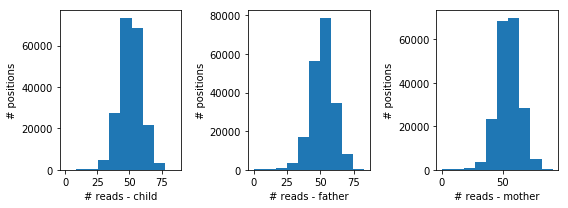

In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np

# All output files will be stored in a week1 folder in your home directory
BASEDIR = os.path.join(os.environ["HOME"], "week1")

# Note we used the pandas library to load the data file
# covdata is a dataframe. use covdata[colname] to access a column
# You can use numpy functions such as np.mean(covdata[colname])
# to compute functions on columns
# Use covdata.head() to view the top of the data frame.
# See more at https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html

def PlotCovDist(plot=False):
    # Compute these values and return below
    mean_child_cov = 0
    mean_father_cov = 0
    mean_mother_cov = 0
    
    # Load coverage ino
    #covdata is a df with child, father, mother as column headers and each row is the number of reads at the bp
    covdata = pd.read_csv(os.path.join(BASEDIR, "trio.mpileup"), sep="\t",
                     names = ["cov.child", "cov.father", "cov.mother"],
                     usecols = [3, 6, 9])

    
    # Plot coverage distributions
    if plot:
        fig = plt.figure()
        fig.set_size_inches((8, 3))
        ax = fig.add_subplot(131)
        ax.hist(covdata["cov.child"])
        ax.set_xlabel("# reads - child")
        ax.set_ylabel("# positions")
        ax = fig.add_subplot(132)
        ax.hist(covdata["cov.father"])
        ax.set_xlabel("# reads - father")
        ax.set_ylabel("# positions")
        ax = fig.add_subplot(133)
        ax.hist(covdata["cov.mother"])
        ax.set_xlabel("# reads - mother")
        ax.set_ylabel("# positions")    
        fig.tight_layout();
    
    # Compute mean coverate of child, father, and mother
    mean_child_cov = np.mean(covdata['cov.child'])
    mean_father_cov = np.mean(covdata['cov.father'])
    mean_mother_cov = np.mean(covdata['cov.mother'])

    # Print out results
    print("Mean child coverage: %d"%mean_child_cov)
    print("Mean father coverage: %d"%mean_father_cov)
    print("Mean mother coverage: %d"%mean_mother_cov)

    # Return results
    return mean_child_cov, mean_father_cov, mean_mother_cov

PlotCovDist(plot=True);

In [2]:
"""Check computed average coverages"""
mean_child_cov, mean_father_cov, mean_mother_cov = PlotCovDist(plot=False)

Mean child coverage: 50
Mean father coverage: 51
Mean mother coverage: 54


## 3. Running a SNP caller (Varscan)

Now we will run a SNP caller to identify variants in our three samples. We could parse the mpileup file ourselves to do this, but there are already dozens of existing SNP callers out there so for now we'll choose not to reinvent the wheel.

Until now, all the programs you have been using (BWA, fastqc, samtools...) were pre-installed for you in our public folder. Here you’ll get to try your hand at installing one type of program file.

Use the command below (`curl` - it's a linux/unix command to access websites) to download VarScan into your `week1` folder. Notice that we are redirecting the contents of the download into a .jar file.

```
curl -L https://sourceforge.net/projects/varscan/files/VarScan.v2.3.9.jar/download > VarScan.jar
```

Try to bring up the man page with:
```
java -jar VarScan.jar
```

This install method won’t be the same for all bioinformatics programs, and it might not even be the same for other java programs, as installing open source software often has dependencies (prerequisite software) and can be sensitive to where its installed and how it is executed. We'll try to touch on this throughout the course.


On the VarScan man page, you should see several commands. We are interested in the `mpileup2snp` command. Go ahead and enter it with `-h` to bring up the manual.

```
java -jar VarScan.jar mpileup2snp -h
```

There are lots of ways we could filter our data. VarScan lets the user define their own cutoffs for including data in calling variants, other programs rely on complex statistical procedures to evaluate the likelihood of real mutations.

The first option we are interested in setting today is the `--min-var-frequency` option. This sets the minimum % of non-reference bases at a position required to call it a variant in the sample. Set this too low, and we'll pick up mostly sequencing errors. Set this too high, and we'll miss real variants. We're also interested in `--min-freq-for-hom`, the minimum % of non-reference bases to call a variant homozygous.

Choose reasonable thresholds that will allow us to pick up both heterozygous and homozygous variants. 

**Question 4 (4 pts)**: Choose reasonable thresholds to modify and run the command below to perform SNP calling. Paste your full command in the next cell. If you are unsure about the values you are putting in, you might want to discuss with your partner or TA since the results will affect what you do in the next part.

```
java -jar VarScan.jar mpileup2snp \
  trio.mpileup \
  --min-var-frequency N \
  --min-freq-for-hom N \
  --variants \
  --p-value 0.01 \
  --output-vcf 1 > trio.vcf
```

java -jar VarScan.jar mpileup2snp \
  trio.mpileup \
  --min-var-frequency 40 \
  --min-freq-for-hom  75 \
  --variants \
  --p-value 0.01 \
  --output-vcf 1 > trio.vcf

## 4. Intro to VCF files

VarScan outputs variants in VCF (variant call format), a standard genomics format. To read about all the gory details of VCF files, see the specs: https://samtools.github.io/hts-specs/VCFv4.2.pdf

First take a peak and scroll through the file:

```
cat trio.vcf | more
```

Key things to notice:

* The header lines (starting with "#") give general information about the file such as the tool use to generate it and a description of all the different data fields in the file.
* Below the header, there is one line per variant. For each variant, you can find the chromosome, position, reference allele, alternate allele, and additional info. Following these fields are the variant call and statistics for each sample
* "INFO" fields describe per-variant statistics. "FORMAT" fields describe per-sample statistics at each variant.

See lecture slides for more VCF info.

**Question 5 (4 pts)**: Look at the position chr6:128593590 (it might be helpful to use grep for this. See example command below). What is the genotype for each of the three samples? What is the p-value for each?

```
grep 128593590 trio.vcf
```

cat trio.vcf | grep 128593590 trio.vcf

chr6    128593590       .       T       G       .       PASS <br>
GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:ADF:ADR <br>
0/0:126:68:68:68:0:0%:1E0:37:0:34:34:0:0 <br>
0/0:85:45:45:45:0:0%:1E0:37:0:19:26:0:0 <br>
0/1:70:52:52:32:20:38.46%:9.8643E-8:36:42:17:15:12:8 <br>

Sample 1 Genotype: 0/0 (homozygous reference), pval = 1E0 <br>
Sample 2 Genotype: 0/0 (homozygous reference), pval = 1E0 <br>
Sample 3 Genotype: 0/1 (heterozygous), pval = 9.8643E-8 <br>

## 5. Mutation identification and annotation

We'd now like to identify potential *de novo* mutations that occurred in the child genome but that were not passed down by either parent. 

**Question 6 (10 pts)** In the space below, write a small program that identifies candidate mutations in the child genome.

You may do this using whatever means you want, but example template code to get you started using the PyVCF library is provided. This can also be done using bash commands. Your code must run from within the notebook and output a list of candidate mutation positions.

Note you could also do this manually, since our VCF file is pretty small. But we will give only 1 point for solutions with no code provided.

The code prints out one line per position genotyped to give you an idea of how PyVCF works. Modify the code so that it returns a list of potentials of de novo mutations.

In [3]:
# This code simply prints out each position in the VCF file and the genotypes
# of each sample. Modify to return a list of positions of potential de novo
# mutations. That is, positions where the child has an allele not seen in 
# either parent.

import vcf

# This code is using the PyVCF library to parse VCFs
# See more here: https://pyvcf.readthedocs.io/en/latest/INTRO.html
# You shouldn't have to deal directly with any PyVCF functions
# in your solution.

def GetDenovoPositions(printpos=False):
    reader = vcf.Reader(open(os.path.join(BASEDIR, "trio.vcf"), "r"))
    positions = []
    
    for record in reader:
        chrom  = record.CHROM # e.g. chr6
        pos = record.POS # e.g. 128414945
        child_gt = record.genotype("Sample1").gt_bases # e.g. 'T/T'
        father_gt = record.genotype("Sample2").gt_bases # e.g. 'T/A'
        mother_gt = record.genotype("Sample3").gt_bases # e.g. 'T/T'

        # If the position is denovo, add pos to positions
        if (child_gt != mother_gt) and (child_gt != father_gt):
            positions.append(pos)
        
        
        if printpos:
            print("%s:%s:%s;%s;%s"%(chrom, pos, child_gt, father_gt, mother_gt))
        
    return positions

GetDenovoPositions(printpos=True)

chr6:128414945:C/T;C/T;C/T
chr6:128419307:T/A;T/A;T/A
chr6:128421762:C/T;C/T;C/T
chr6:128435303:C/T;C/T;C/T
chr6:128442104:G/G;G/G;G/T
chr6:128446509:C/T;C/T;C/T
chr6:128450019:T/G;T/G;T/T
chr6:128465668:C/T;C/C;C/T
chr6:128469937:T/A;T/A;T/A
chr6:128471913:A/C;A/C;A/C
chr6:128484504:A/G;A/G;A/A
chr6:128486139:A/C;A/C;A/C
chr6:128488195:T/C;T/C;T/C
chr6:128493991:G/T;G/T;G/T
chr6:128494093:C/G;C/G;C/G
chr6:128496528:T/T;T/T;T/C
chr6:128496557:C/T;C/T;C/T
chr6:128503550:T/C;T/C;T/T
chr6:128505804:A/C;A/A;A/A
chr6:128514053:G/A;G/A;G/A
chr6:128515718:T/C;T/C;T/T
chr6:128517169:T/T;T/T;T/C
chr6:128532763:G/C;G/C;G/C
chr6:128559329:C/T;C/T;C/T
chr6:128564669:G/T;G/T;G/T
chr6:128568999:C/T;C/T;C/C
chr6:128572877:C/A;C/A;C/A
chr6:128583972:G/A;G/G;G/A
chr6:128583983:T/G;T/T;T/G
chr6:128585618:A/C;A/C;A/C
chr6:128591818:T/G;T/G;T/G
chr6:128593590:T/T;T/T;T/G
chr6:128599580:C/A;C/A;C/A
chr6:128599902:C/A;C/A;C/A
chr6:128602090:A/C;A/C;A/C
chr6:128602577:T/C;T/C;T/C
chr6:128602796:C/T;C/T;C/T
c

[128505804]

In [4]:
""" Check the list of positions returned"""
positions = GetDenovoPositions(printpos=False)

Now let's figure out if the mutations identified are likely to have an impact on any particular genes. We'll use the UCSC Genome Browser (https://genome.ucsc.edu/) to help with this. Go to the genome browser home page. Then on the top menu bar, hover over "Genomes" and choose the hg19 reference genome.

**Question 7 (5 pts)**: In the search bar, navigate to the position of each mutation. e.g. "chr6:XXXX" in the search bar. Does any mutation fall within a gene? If yes, determine whether it is predicted to change the amino acid structure (i.e. is this a synonymous variant? missense? nonsense?) of the protein and describe the change below. Make sure to determine which strand the gene is on! (forward vs. reverse)

Looking up the specific location on UCSD gene browser, position 128505804, falls within the gene PTPRK. The reference genome has the bp A while the variant in question is C. The current triplet that the position is a part of codes for the amino acid L (CUA -> Leucine). For the gene, it is on the reverse strand. If the variant is substituted instead the amino acid becomes R (CGA -> Arginine). This is a missense mutation.

# 6. Additional challenge questions

Provide short answers for each question below. Please no more than 3-5 sentences for each.

**Question 8 (5 pts)**: You sequenced the genome of a patient in your clinic with a suspected neurodevelopmental disorder and plotted the distribution of coverage across all bases of the genome. The mean coverage is around 40x, with most bases covered between 20-60 times. However you notice some bases are never covered (0 coverage) and other bases have extremely large coverages (1000x). Describe what could be happening at positions with extremely low or high coverage. 

There are many locations in the whole workflow where this error can come from. The first thing to look into would be the alignment of the fragments. There could be missaligned sequences that are congregating in similar spots causing some areas to have high reads as well as some having little to none. There could also be duplicate reads for parts of sequences as well as contamination/low quality in sequences causing the duplicates/misalignments. Another possiblity is the pcr amplification step.

**Question 9 (5 pts)**: For the same individual's genome, you plot the template length distribution (similar to how we did in Tuesday's lab.) If you plot the distribution over the entire genome, you see a mean template length of around 300bp. However, when you zoom in on region of the genome you expect is involved in the patient's disorder, you see a bimodal plot, with a peak at the expected 300bp and another at around 350bp. What could explain this?

This could be cause by the workflow of how the sequences/fragments are produced. Different methods of sequncing (Sanger) and the quality of those runs.

**Question 9 (5 pts)**: You are sequencing the genome of a tetraploid genome (4 copies of the genome, rather than 2 like diploid humans). At a position with 30x coverage where only one of the four copies of the genome contains a variant from the reference genome, how many reads do you expect on average to have the variant?

You would expect 7-8 of the reads to contain the variant. This is cound by 30(total reads)/4(tetraploid) = 7.5 or 25% of the reads.

## 7. Submit the assignment!

Under the "Assignment" tab in JupyterHub, for the Lab1 assignment you should see buttons:

* Validate: lets you check if your notebooks are passing all tests (including hidden tests)
* Submit: will submit your assignment!

Be sure to submit before lecture Monday (9am 4/8/19)